In [ ]:
import numpy as np
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib notebook

mpl.rcParams['axes.spines.top'] = 0
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['axes.spines.left'] = 1
mpl.rcParams['axes.spines.bottom'] = 1
mpl.rcParams.update({'font.size': 12})

In [25]:
image_size = (250, 250)
scale = 0

noise = np.zeros((2, *image_size))

noise[0] = scale * np.random.randn(*image_size)
noise[1] = scale * np.random.randn(*image_size)

# noise[1] = -noise[0] # homework

from pathlib import Path
result = list(Path('/Users/dokman0000/Downloads/lfw/').rglob('*.jpg'))

n_train = 1000
n_test = 100
images = np.zeros((n_train, 250, 250))
labels = np.zeros((n_train,), dtype=np.int8)

images_test = np.zeros((n_test, 250, 250))
labels_test = np.zeros((n_test,), dtype=np.int8)

shuffle_idx = np.random.permutation(n_train + n_test)
for i in range(n_train):
    images[i] = plt.imread(result[shuffle_idx[i]]).mean(axis=2)
    labels[i] = np.round(np.random.rand())
    images[i] += noise[labels[i]]

for i in range(n_train, n_train + n_test):
    images_test[i - n_train] = plt.imread(result[shuffle_idx[i]]).mean(axis=2)
    labels_test[i - n_train] = np.round(np.random.rand())
    # no noise in the test set!

# Let us start with an experiment

- we have dataset of face images of a group of people
- some of them are dog people, some of them, evidently, cat people
- our task is to classify them as such by looking at their face

<IPython.core.display.Javascript object>


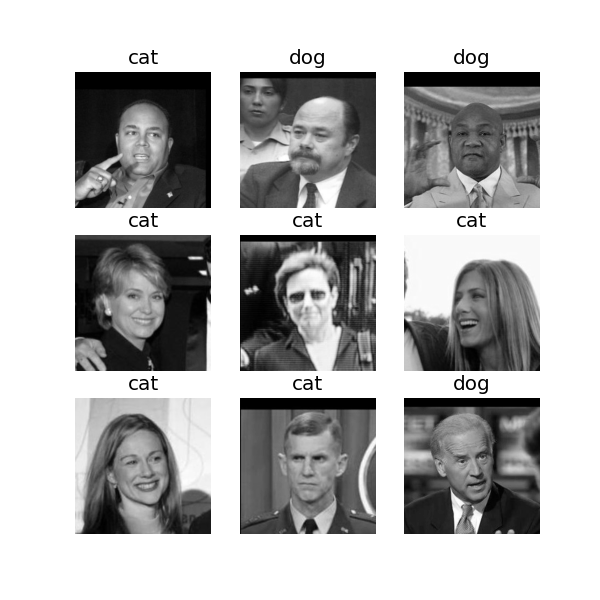

(1000, 250, 250)


In [26]:
n_plots = 3
fig, axs = plt.subplots(n_plots, n_plots, figsize=(6, 6))

print(images.shape)
 
text_label = ['dog', 'cat']
for i in range(n_plots):
    for j in range(n_plots):
        axs[i, j].imshow(images[i*n_plots + j], cmap='gray');
        axs[i, j].axis('off')
        axs[i, j].set_title(text_label[labels[i*n_plots + j]])

# Let's try the simple perceptron

In [27]:
def train(X, y, lr=1, n_iter=30):
    # X : a (n, d) matrix with rows being training examples (digits)
    # y : a (n, 1) vector of labels

    n, d = X.shape
    w = np.zeros((d,))
    
    for i_iter in range(n_iter):
        for i_example in range(n):
            y_est = np.sign(np.dot(X[i_example], w))

            if y_est != y[i_example]:
                w += lr * X[i_example] * y[i_example]
        
    return w


labsym = labels*2 - 1
w = train(images.reshape(n_train, -1), labsym)

In [28]:
labsym_est = np.sign(images.reshape(n_train, -1) @ w)
labels_est = np.int8((labsym_est + 1) / 2)
n_correct = np.sum(labsym_est == labsym)
print('The perceptron correctly classifies %d out of %d training images' % (n_correct, n_train))

The perceptron correctly classifies 814 out of 1000 training images


<IPython.core.display.Javascript object>


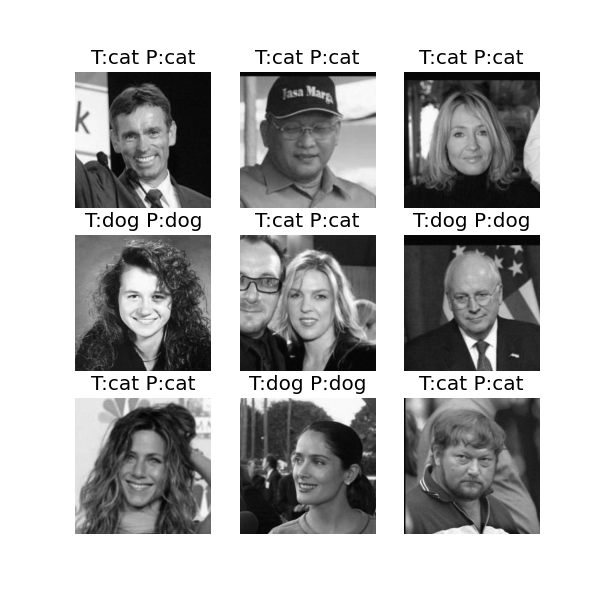

In [19]:
fig, axs = plt.subplots(n_plots, n_plots, figsize=(6, 6))

for i in range(n_plots):
    for j in range(n_plots):
        axs[i, j].imshow(images[i*n_plots + j], cmap='gray');
        axs[i, j].axis('off')
        axs[i, j].set_title('T:' + text_label[labels[i*n_plots + j]] \
                            + ' P:' + text_label[labels_est[i*n_plots + j]])

# Phenomenal and strange!

## We also have a test set...


In [29]:
labsym_test = labels_test*2 - 1
labsym_test_est = np.sign(images_test.reshape(n_test, -1) @ w)

n_correct_test = np.sum(labsym_test_est == labsym_test)
print('The perceptron correctly classifies %d out of %d test images' % (n_correct_test, n_test))

The perceptron correctly classifies 52 out of 100 test images


# What went wrong?

We built a classifier which does not _generalize_ well.

But why? How can it work so well on the training data? The answer is that I tricked you. I doctored the images in an impercetible way. First, I generated two images of pure noise.

<IPython.core.display.Javascript object>


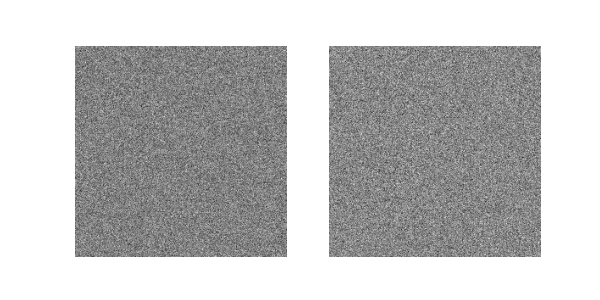

In [23]:
scale = 2
noise = np.zeros((2, *image_size))
noise[0] = scale * np.random.randn(*image_size)
noise[1] = scale * np.random.randn(*image_size)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(noise[0], cmap='gray')
axs[0].axis('off')
axs[1].imshow(noise[1], cmap='gray')
axs[1].axis('off');

Then I 
- randomly assigned labels to training images
- to every random dog person I added noise[0]
- to every random cat person I added noise[1]

In [ ]:
for i in range(n_train):
    images[i] = plt.imread(result[shuffle_idx[i]]).mean(axis=2)
    labels[i] = np.round(np.random.rand())
    images[i] += noise[labels[i]]

# To really understand why it works

- The key is in angles! High-dimensional Gaussian random vectors are near-orthogonal...
- This can be understood already by the law of large numbers!

In [24]:
def angle(x, y):
    return 180 / np.pi * np.arccos(np.dot(x.flatten(), y.flatten()) / \
                                   np.linalg.norm(x.flatten()) / \
                                   np.linalg.norm(y.flatten())
                                  )

angle(noise[0], images[0])

90.33479994480324

but $\langle \mathbf{x} + \mathbf{e_0}, \mathbf{e_0} \rangle = \langle \mathbf{x}, \mathbf{e_0} \rangle + \langle \mathbf{e_0}, \mathbf{e_0} \rangle \approx 0 + \| \mathbf{e_0} \|^2$

while $\langle \mathbf{x} + \mathbf{e_1}, \mathbf{e_0} \rangle = \langle \mathbf{x}, \mathbf{e_0} \rangle + \langle \mathbf{e_1}, \mathbf{e_0} \rangle \approx 0 + 0$


# Clever Hans (der Kluge Hans)
<br>
<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/CleverHans.jpg" width="50%" />
</center>

I very much like the Wikipedia description:

    Hans was a horse owned by Wilhelm von Osten, who was a gymnasium mathematics teacher, an 
    amateur horse trainer, phrenologist, and considered a mystic.

# Generalization

- We say that our classifier or predictor **fails to generalize** (from training to test cases)
- Since we have great train performance, this is an example of **overfitting**: we achieve extremely good performance on the train set but it does not say anything about the test set (in fact, it is detrimental)
- Unlike classical overfitting to independent noise, our dataset was additionally doctored!

_Generalization is the ability of a pattern recognition system to do well on data that it hasn't seen in the training phase._

# Quiz

- How would $k$-means perform on catness and dogness? Could it be fooled as well?
- Recall our set of threshold-based clasifiers:

$$
  \mathcal{A} = \text{the set of algorithms} = \left\{ f(x) = \begin{cases} 0 & \text{if}~ x \leq \eta \\ 1 & \text{if}~ x > \eta \end{cases} \ \bigg| \ \eta \in \mathbb{R} \right \}
$$
- Write down in a similar form the set of all perceptrons that work on 100-dimensional vectors

